# Parisian Barrier Option — Applications

Prototype to price Parisian barriers, track the barrier clock, and frame knock-in autocall ideas. Everything runs off the Monte Carlo engine with optional Brownian bridge densification so the discrete monitoring bias stays contained.


In [1]:
import pathlib
import sys


def find_project_root(marker: str = "src") -> pathlib.Path:
    here = pathlib.Path.cwd().resolve()
    for candidate in [here, *here.parents]:
        if (candidate / marker).is_dir():
            return candidate
    raise RuntimeError(
        f"Unable to locate project root containing '{marker}' directory starting from {here}"
    )


PROJECT_ROOT = find_project_root()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.models import MonteCarloEngine
from src.pricing import (
    bs_price,
    parisian_first_hit_time,
    parisian_indicator,
    parisian_occupation_time,
    parisian_option_payoff,
)
from src.utils import summarise_parisian_paths

plt.style.use("seaborn-v0_8-darkgrid")

trade = {
    "S0": 100.0,
    "K": 105.0,
    "T": 3.0,
    "r": 0.04,
    "q": 0.01,
    "sigma": 0.20,
    "barrier": 95.0,
    "window": 0.5,
    "option_type": "call",
    "direction": "down",
    "inout": "in",
    "style": "cumulative",
    "within": "loglinear",
}

engine_kwargs = dict(
    n_paths=80000,
    n_steps=96,
    seed=7,
    antithetic=True,
    stratified=True,
)

sample_trades = pd.read_csv(PROJECT_ROOT / "data" / "sample" / "trade_params.csv")
sample_trades

,trade_id,S0,K,T,r,q,sigma,barrier,window,option_type,inout,direction,style,within,comment
0,PX1,100,100,0.25,0.020,0.00,0.20,95,0.15,call,in,down,cumulative,loglinear,Desk benchmark knock-in call
1,PX2,100,95,0.50,0.020,0.00,0.18,90,0.12,call,out,down,cumulative,loglinear,Tighter window for defensive autocall
2,PX3,100,105,0.75,0.015,0.01,0.22,110,0.20,put,in,up,cumulative,loglinear,Up-and-in hedge look


## Pricing logic overview

Brownian bridge refines each coarse step, giving the Parisian clock fractional time inside the window instead of the crude grid hit/miss. Below we overlay the coarse vs refined path for one Monte Carlo draw.


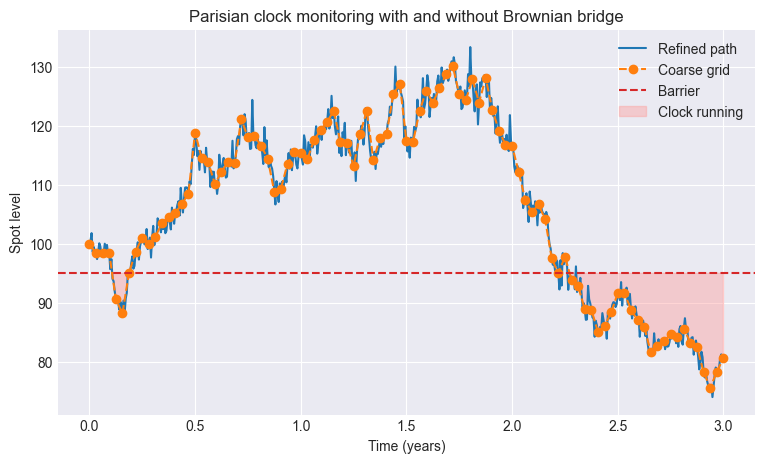

In [2]:
def run_engine(
    *,
    brownian_bridge: bool,
    bb_refine: int = 8,
    bb_mode: str = "refine",
    **overrides,
):
    params = {**trade, **overrides}
    engine = MonteCarloEngine(
        S0=params["S0"],
        K=params["K"],
        T=params["T"],
        r=params["r"],
        q=params["q"],
        sigma=params["sigma"],
        model="GBM",
        brownian_bridge=brownian_bridge,
        bb_refine=bb_refine,
        bb_mode=bb_mode,
        **engine_kwargs,
    )
    paths = engine.simulate_paths()
    dt = params["T"] / (paths.shape[0] - 1)

    payoff_in = parisian_option_payoff(
        paths,
        K=params["K"],
        r=params["r"],
        T=params["T"],
        barrier=params["barrier"],
        dt=dt,
        window=params["window"],
        option_type=params["option_type"],
        inout="in",
        direction=params["direction"],
        style=params["style"],
        within=params["within"],
    )
    payoff_out = parisian_option_payoff(
        paths,
        K=params["K"],
        r=params["r"],
        T=params["T"],
        barrier=params["barrier"],
        dt=dt,
        window=params["window"],
        option_type=params["option_type"],
        inout="out",
        direction=params["direction"],
        style=params["style"],
        within=params["within"],
    )

    price_in = float(payoff_in.mean())
    se_in = float(payoff_in.std(ddof=1) / np.sqrt(payoff_in.size))
    price_out = float(payoff_out.mean())
    se_out = float(payoff_out.std(ddof=1) / np.sqrt(payoff_out.size))
    vanilla = bs_price(
        params["S0"],
        params["K"],
        params["T"],
        params["r"],
        params["q"],
        params["sigma"],
        params["option_type"],
    )

    summary = summarise_parisian_paths(
        paths,
        barrier=params["barrier"],
        dt=dt,
        window=params["window"],
        direction=params["direction"],
        style=params["style"],
        within=params["within"],
    )
    first_hit = parisian_first_hit_time(
        paths,
        barrier=params["barrier"],
        dt=dt,
        window=params["window"],
        direction=params["direction"],
        style=params["style"],
        within=params["within"],
    )

    return dict(
        engine=engine,
        params=params,
        paths=paths,
        dt=dt,
        price_in=price_in,
        se_in=se_in,
        price_out=price_out,
        se_out=se_out,
        vanilla=vanilla,
        summary=summary,
        first_hit=first_hit,
    )

coarse = run_engine(brownian_bridge=False)
bridge = run_engine(brownian_bridge=True, bb_refine=6)

sample_idx = 0
time_coarse = np.linspace(0.0, trade["T"], coarse["paths"].shape[0])
time_bridge = np.linspace(0.0, trade["T"], bridge["paths"].shape[0])

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(time_bridge, bridge["paths"][:, sample_idx], label="Refined path", color="#1f77b4")
ax.plot(time_coarse, coarse["paths"][:, sample_idx], "o--", label="Coarse grid", color="#ff7f0e")
ax.axhline(trade["barrier"], color="#d62728", linestyle="--", label="Barrier")
mask = bridge["paths"][:, sample_idx] < trade["barrier"]
ax.fill_between(
    time_bridge,
    bridge["paths"][:, sample_idx],
    trade["barrier"],
    where=mask,
    color="#ff9896",
    alpha=0.4,
    interpolate=True,
    label="Clock running",
)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Spot level")
ax.set_title("Parisian clock monitoring with and without Brownian bridge")

ax.legend()
plt.show()


## Monte Carlo pricing snapshot

Refined monitoring preserves parity with the vanilla reference and lifts the hit ratio. Same random seeds so the comparison is path-for-path.


In [3]:
pricing_df = pd.DataFrame(
    [
        {
            "Brownian bridge": "No",
            "IN price": coarse["price_in"],
            "IN stderr": coarse["se_in"],
            "OUT price": coarse["price_out"],
            "OUT stderr": coarse["se_out"],
            "IN + OUT": coarse["price_in"] + coarse["price_out"],
            "Vanilla ref": coarse["vanilla"],
            "Hit ratio": coarse["summary"].hit_ratio,
        },
        {
            "Brownian bridge": "Yes",
            "IN price": bridge["price_in"],
            "IN stderr": bridge["se_in"],
            "OUT price": bridge["price_out"],
            "OUT stderr": bridge["se_out"],
            "IN + OUT": bridge["price_in"] + bridge["price_out"],
            "Vanilla ref": bridge["vanilla"],
            "Hit ratio": bridge["summary"].hit_ratio,
        },
    ]
).assign(Parity=lambda df: df["IN + OUT"] - df["Vanilla ref"]).round(6)
pricing_df


,Brownian bridge,IN price,IN stderr,OUT price,OUT stderr,IN + OUT,Vanilla ref,Hit ratio,Parity
0,No,2.466002,0.031804,12.750034,0.088987,15.216036,15.125628,0.590638,0.090408
1,Yes,2.476661,0.031904,12.739375,0.088966,15.216036,15.125628,0.591738,0.090408


## Barrier clock analytics

The desk checks how often we spend enough time below the barrier, how much time we clock on average, and when the first hit typically happens.


In [4]:
dt = bridge["dt"]
paths = bridge["paths"]
summary_df = (
    pd.DataFrame([bridge["summary"].to_dict()])
    .rename(
        columns={
            "hit_ratio": "Hit ratio",
            "avg_occupation": "Avg time below barrier",
            "avg_occupation_hit": "Avg time when hit",
            "window": "Barrier window",
            "avg_terminal": "Avg terminal spot",
            "avg_hit_time": "Avg hit time",
            "avg_hit_time_hit": "Avg hit time (when hit)",
        }
    )
    .round(6)
)
summary_df


,Hit ratio,Avg time below barrier,Avg time when hit,Barrier window,Avg terminal spot,Avg hit time,Avg hit time (when hit)
0,0.591738,1.110696,1.799109,0.5,109.466244,1.203952,1.203952


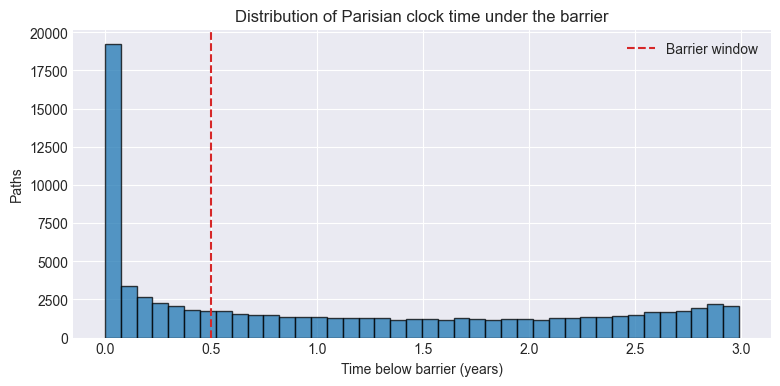

In [5]:
occupation = parisian_occupation_time(
    paths,
    barrier=trade["barrier"],
    dt=dt,
    direction=trade["direction"],
    within=trade["within"],
)

plt.figure(figsize=(9, 4))
plt.hist(occupation, bins=40, color="#1f77b4", alpha=0.75, edgecolor="black")
plt.axvline(trade["window"], color="#d62728", linestyle="--", label="Barrier window")
plt.title("Distribution of Parisian clock time under the barrier")
plt.xlabel("Time below barrier (years)")
plt.ylabel("Paths")
plt.legend()
plt.show()


## Barrier knock-in

Treat the hit an 8% coupon trigger on 100 notional. We track the probability of paying, the PV of that coupon, and when it typically switches on.


In [6]:
coupon_rate = 0.08
notional = 100.0
coupon_amount = coupon_rate * notional

hit_times = bridge["first_hit"]
hit_mask = np.isfinite(hit_times)
discounted_coupon = np.zeros_like(hit_times)
discounted_coupon[hit_mask] = coupon_amount * np.exp(-trade["r"] * hit_times[hit_mask])
expected_coupon_pv = discounted_coupon.mean()

quantiles = (
    np.quantile(hit_times[hit_mask], [0.25, 0.5, 0.75]) if hit_mask.any() else np.array([np.nan] * 3)
)

autocall_metrics = pd.DataFrame(
    [
        {"Metric": "Hit ratio", "Value": bridge["summary"].hit_ratio},
        {"Metric": "Expected coupon PV", "Value": expected_coupon_pv},
        {"Metric": "Effective yield on notional", "Value": expected_coupon_pv / notional},
        {"Metric": "Median hit time", "Value": quantiles[1]},
        {"Metric": "75th percentile hit time", "Value": quantiles[2]},
    ]
).round(6)
autocall_metrics


,Metric,Value
0,Hit ratio,0.591738
1,Expected coupon PV,4.512805
2,Effective yield on notional,0.045128
3,Median hit time,0.976934
4,75th percentile hit time,1.564462


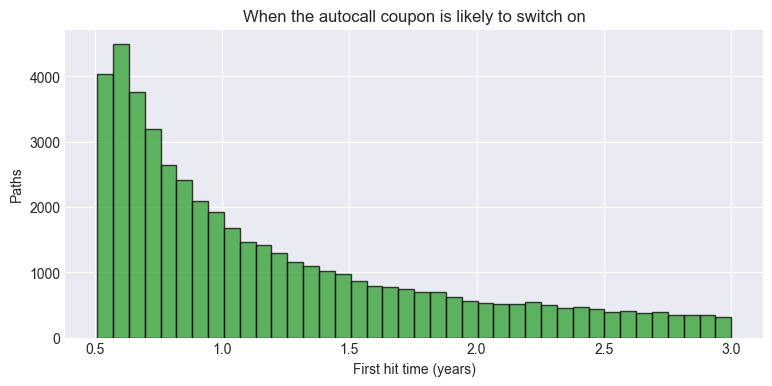

In [7]:
if hit_mask.any():
    plt.figure(figsize=(9, 4))
    plt.hist(hit_times[hit_mask], bins=40, color="#2ca02c", alpha=0.75, edgecolor="black")
    plt.title("When the autocall coupon is likely to switch on")
    plt.xlabel("First hit time (years)")
    plt.ylabel("Paths")
    plt.show()
else:
    print("No hits recorded with current parameters.")


## Barrier window stress

Slide the window to brief how the IN price, hit ratio, and coupon PV move together. Brownian bridge stays on for consistency.


In [8]:
window_grid = np.linspace(0.10, 0.30, 6)
rows = []
for window in window_grid:
    snap = run_engine(brownian_bridge=True, window=float(window))
    hit_times = snap["first_hit"]
    mask = np.isfinite(hit_times)
    discounted = np.zeros_like(hit_times)
    discounted[mask] = coupon_amount * np.exp(-snap["params"]["r"] * hit_times[mask])
    rows.append(
        {
            "Window": window,
            "IN price": snap["price_in"],
            "StdErr": snap["se_in"],
            "Hit ratio": snap["summary"].hit_ratio,
            "Avg time below barrier": snap["summary"].avg_occupation,
            "Expected coupon PV": discounted.mean(),
        }
    )

window_df = pd.DataFrame(rows).round(6)
window_df


,Window,IN price,StdErr,Hit ratio,Avg time below barrier,Expected coupon PV
0,0.10,5.654222,0.052253,0.743825,1.110661,5.792938
1,0.14,5.096974,0.049146,0.722025,1.110627,5.607509
2,0.18,4.627645,0.046480,0.702262,1.110672,5.440687
3,0.22,4.257721,0.044191,0.685762,1.110727,5.300341
4,0.26,3.903029,0.042010,0.670025,1.110680,5.167223
5,0.30,3.586949,0.039885,0.655300,1.110710,5.043085


## Delta and vega 

one-basis spot bump and +1 vol point move, still using the refined monitoring so noise stays contained.


In [9]:
base_price = bridge["price_in"]
bump = 0.01

spot_up = run_engine(brownian_bridge=True, S0=trade["S0"] * (1 + bump))
vol_up = run_engine(brownian_bridge=True, sigma=trade["sigma"] + 0.01)

delta = (spot_up["price_in"] - base_price) / (trade["S0"] * bump)
vega = (vol_up["price_in"] - base_price) / 0.01

pd.DataFrame(
    [
        {"Measure": "Delta", "Value": delta},
        {"Measure": "Vega", "Value": vega},
    ]
).round(6)


,Measure,Value
0,Delta,-0.169672
1,Vega,22.127797
